<a href="https://colab.research.google.com/github/Shamymash/Cactus-LoginRegister/blob/master/CNNPred_CNN_based_Stock_Market_Prediction_Using_a_Diverse_Set_of_Variables.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
!git clone https://github.com/thuml/Time-Series-Library.git
%cd Time-Series-Library

Cloning into 'Time-Series-Library'...
remote: Enumerating objects: 2023, done.
remote: Counting objects: 100% (112/112), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 2023 (delta 81), reused 63 (delta 63), pack-reused 1911 (from 3)
Receiving objects: 100% (2023/2023), 78.28 MiB | 15.38 MiB/s, done.
Resolving deltas: 100% (1389/1389), done.
/content/Time-Series-Library/Time-Series-Library


In [2]:
!pip install einops yacs scikit-learn matplotlib pandas

In [43]:
from google.colab import files
uploaded = files.upload()


Saving PatchTST.py to PatchTST (1).py
Saving Processed_DJI.csv to Processed_DJI (1).csv
Saving Processed_NASDAQ.csv to Processed_NASDAQ (1).csv
Saving Processed_NYSE.csv to Processed_NYSE (1).csv
Saving Processed_RUSSELL.csv to Processed_RUSSELL (1).csv
Saving Processed_S&P.csv to Processed_S&P (1).csv


In [45]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
import pandas as pd

df = pd.read_csv('Processed_S&P.csv')
df.head()


,Date,Close,Volume,mom,mom1,mom2,mom3,ROC_5,ROC_10,ROC_15,...,NZD,silver-F,RUSSELL-F,S&P-F,CHF,Dollar index-F,Dollar index,wheat-F,XAG,XAU
0,2009-12-31,1115.099976,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.03,0.26,-1.08,-1.00,-0.11,-0.08,-0.06,-0.48,0.30,0.39
1,2010-01-04,1132.989990,0.921723,0.016043,NaN,NaN,NaN,NaN,NaN,NaN,...,1.52,3.26,1.61,1.62,-0.57,-0.59,-0.42,3.12,3.91,2.10
2,2010-01-05,1136.520020,-0.375903,0.003116,0.016043,NaN,NaN,NaN,NaN,NaN,...,-0.07,1.96,-0.20,0.31,0.43,0.03,0.12,-0.90,1.42,-0.12
3,2010-01-06,1137.140015,0.996234,0.000546,0.003116,0.016043,NaN,NaN,NaN,NaN,...,0.56,2.15,-0.02,0.07,-0.56,-0.24,-0.17,2.62,2.25,1.77
4,2010-01-07,1141.689941,0.059932,0.004001,0.000546,0.003116,0.016043,NaN,NaN,NaN,...,-0.72,0.94,0.50,0.40,0.58,0.58,0.54,-1.85,0.22,-0.58


In [69]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from PatchTST import Model

def prepare_data(filename, window_size=30, pred_horizon=1):
    df = pd.read_csv(filename)
    if 'Date' in df.columns:
        df = df.drop(columns=["Date"])
    df_numeric = df.select_dtypes(include=[np.number])
    print(f"Using numeric columns: {df_numeric.columns.tolist()}")
    num_features = len(df_numeric.columns)
    df_dropna = df_numeric.dropna()
    data = df_dropna.values
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)
    X, y = [], []
    for i in range(len(data_scaled) - window_size - pred_horizon + 1):
        X.append(data_scaled[i:i + window_size])
        y.append(data_scaled[i + window_size + pred_horizon - 1, 0])  # predicting Close
    return np.array(X), np.array(y), scaler, num_features

# Call the prepare_data function with the filename (assuming it's in the root directory)
X, y, scaler, num_features = prepare_data("/Processed_SP.csv", window_size=30, pred_horizon=1)

print(f"Number of input features (enc_in): {num_features}")

config = {
    'task_name': 'long_term_forecast',
    'seq_len': 30,  # Set seq_len to your window_size
    'pred_len': 1,   # Set pred_len to your pred_horizon
    'd_model': 128,
    'n_heads': 8,
    'd_ff': 256,
    'e_layers': 3,
    'dropout': 0.1,
    'factor': 5,
    'activation': 'relu',
    'enc_in': num_features  # Use the determined number of input features
}

# Initialize the model
model = Model(config)

Using numeric columns: ['Close', 'Volume', 'mom', 'mom1', 'mom2', 'mom3', 'ROC_5', 'ROC_10', 'ROC_15', 'ROC_20', 'EMA_10', 'EMA_20', 'EMA_50', 'EMA_200', 'DTB4WK', 'DTB3', 'DTB6', 'DGS5', 'DGS10', 'Oil', 'Gold', 'DAAA', 'DBAA', 'GBP', 'JPY', 'CAD', 'CNY', 'AAPL', 'AMZN', 'GE', 'JNJ', 'JPM', 'MSFT', 'WFC', 'XOM', 'FCHI', 'FTSE', 'GDAXI', 'DJI', 'HSI', 'IXIC', 'SSEC', 'RUT', 'NYSE', 'TE1', 'TE2', 'TE3', 'TE5', 'TE6', 'DE1', 'DE2', 'DE4', 'DE5', 'DE6', 'CTB3M', 'CTB6M', 'CTB1Y', 'AUD', 'Brent', 'CAC-F', 'copper-F', 'WIT-oil', 'DAX-F', 'DJI-F', 'EUR', 'FTSE-F', 'gold-F', 'HSI-F', 'KOSPI-F', 'NASDAQ-F', 'GAS-F', 'Nikkei-F', 'NZD', 'silver-F', 'RUSSELL-F', 'S&P-F', 'CHF', 'Dollar index-F', 'Dollar index', 'wheat-F', 'XAG', 'XAU']
Number of input features (enc_in): 82



--- Processing dataset: Processed_SP.csv ---
Current working directory: /content/Time-Series-Library/utils
Checking for file: Processed_SP.csv
Using numeric columns from Processed_SP.csv: ['Close', 'Volume', 'mom', 'mom1', 'mom2', 'mom3', 'ROC_5', 'ROC_10', 'ROC_15', 'ROC_20', 'EMA_10', 'EMA_20', 'EMA_50', 'EMA_200', 'DTB4WK', 'DTB3', 'DTB6', 'DGS5', 'DGS10', 'Oil', 'Gold', 'DAAA', 'DBAA', 'GBP', 'JPY', 'CAD', 'CNY', 'AAPL', 'AMZN', 'GE', 'JNJ', 'JPM', 'MSFT', 'WFC', 'XOM', 'FCHI', 'FTSE', 'GDAXI', 'DJI', 'HSI', 'IXIC', 'SSEC', 'RUT', 'NYSE', 'TE1', 'TE2', 'TE3', 'TE5', 'TE6', 'DE1', 'DE2', 'DE4', 'DE5', 'DE6', 'CTB3M', 'CTB6M', 'CTB1Y', 'AUD', 'Brent', 'CAC-F', 'copper-F', 'WIT-oil', 'DAX-F', 'DJI-F', 'EUR', 'FTSE-F', 'gold-F', 'HSI-F', 'KOSPI-F', 'NASDAQ-F', 'GAS-F', 'Nikkei-F', 'NZD', 'silver-F', 'RUSSELL-F', 'S&P-F', 'CHF', 'Dollar index-F', 'Dollar index', 'wheat-F', 'XAG', 'XAU']
Epoch 1/10, Training Loss: 0.0523
Epoch 2/10, Training Loss: 0.0477
Epoch 3/10, Training Loss: 0.047

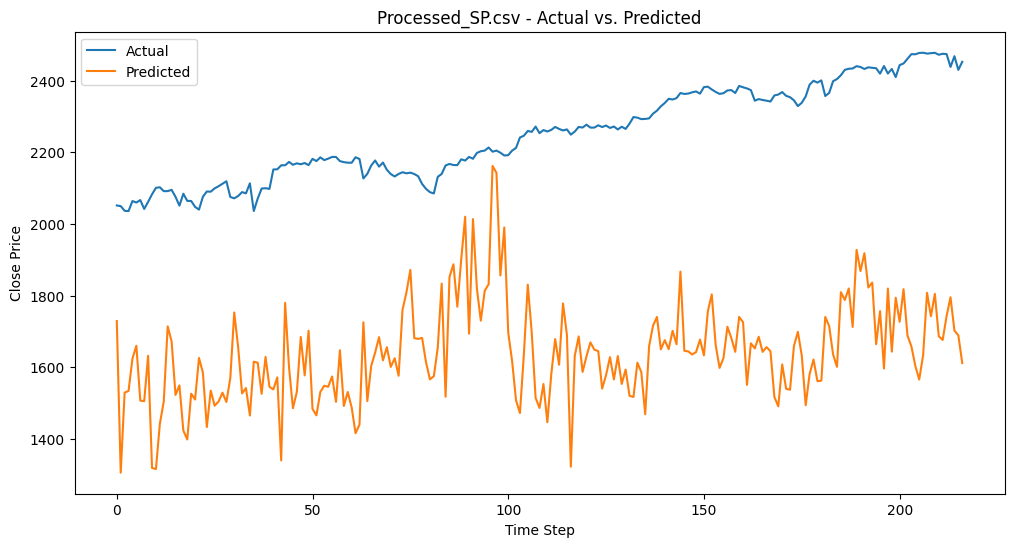

Model saved to model_Processed_SP.pth
✅ Finished processing dataset: Processed_SP.csv

--- Processing dataset: Processed_RUSSELL.csv ---
Current working directory: /content/Time-Series-Library/utils
Checking for file: Processed_RUSSELL.csv
Using numeric columns from Processed_RUSSELL.csv: ['Close', 'Volume', 'mom', 'mom1', 'mom2', 'mom3', 'ROC_5', 'ROC_10', 'ROC_15', 'ROC_20', 'EMA_10', 'EMA_20', 'EMA_50', 'EMA_200', 'DTB4WK', 'DTB3', 'DTB6', 'DGS5', 'DGS10', 'Oil', 'Gold', 'DAAA', 'DBAA', 'GBP', 'JPY', 'CAD', 'CNY', 'AAPL', 'AMZN', 'GE', 'JNJ', 'JPM', 'MSFT', 'WFC', 'XOM', 'FCHI', 'FTSE', 'GDAXI', 'DJI', 'HSI', 'IXIC', 'SSEC', 'S&P', 'NYSE', 'TE1', 'TE2', 'TE3', 'TE5', 'TE6', 'DE1', 'DE2', 'DE4', 'DE5', 'DE6', 'CTB3M', 'CTB6M', 'CTB1Y', 'AUD', 'Brent', 'CAC-F', 'copper-F', 'WIT-oil', 'DAX-F', 'DJI-F', 'EUR', 'FTSE-F', 'gold-F', 'HSI-F', 'KOSPI-F', 'NASDAQ-F', 'GAS-F', 'Nikkei-F', 'NZD', 'silver-F', 'RUSSELL-F', 'S&P-F', 'CHF', 'Dollar index-F', 'Dollar index', 'wheat-F', 'XAG', 'XAU']

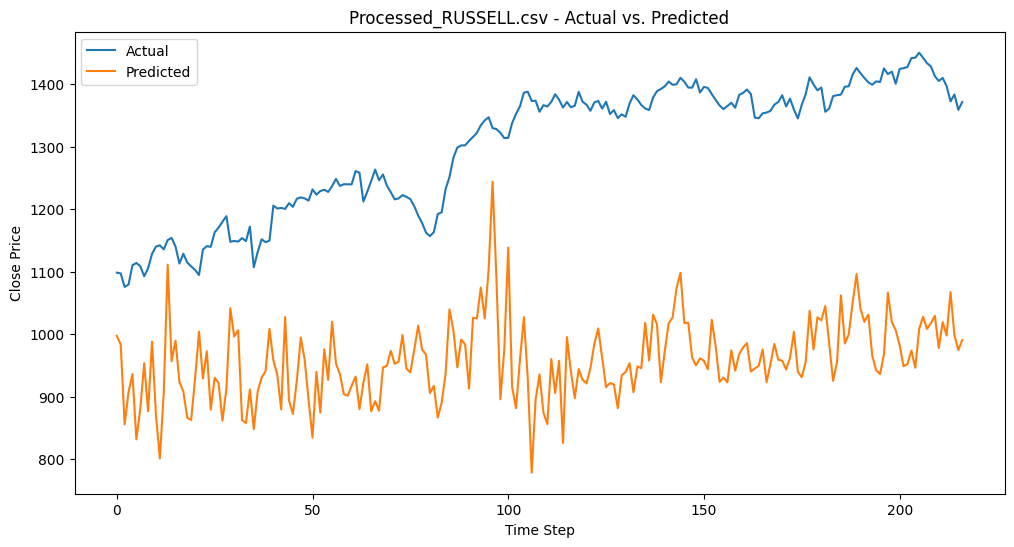

Model saved to model_Processed_RUSSELL.pth
✅ Finished processing dataset: Processed_RUSSELL.csv

--- Processing dataset: Processed_NYSE.csv ---
Current working directory: /content/Time-Series-Library/utils
Checking for file: Processed_NYSE.csv
Using numeric columns from Processed_NYSE.csv: ['Close', 'Volume', 'mom', 'mom1', 'mom2', 'mom3', 'ROC_5', 'ROC_10', 'ROC_15', 'ROC_20', 'EMA_10', 'EMA_20', 'EMA_50', 'EMA_200', 'DTB4WK', 'DTB3', 'DTB6', 'DGS5', 'DGS10', 'Oil', 'Gold', 'DAAA', 'DBAA', 'GBP', 'JPY', 'CAD', 'CNY', 'AAPL', 'AMZN', 'GE', 'JNJ', 'JPM', 'MSFT', 'WFC', 'XOM', 'FCHI', 'FTSE', 'GDAXI', 'DJI', 'HSI', 'IXIC', 'SSEC', 'S&P', 'RUT', 'TE1', 'TE2', 'TE3', 'TE5', 'TE6', 'DE1', 'DE2', 'DE4', 'DE5', 'DE6', 'CTB3M', 'CTB6M', 'CTB1Y', 'AUD', 'Brent', 'CAC-F', 'copper-F', 'WIT-oil', 'DAX-F', 'DJI-F', 'EUR', 'FTSE-F', 'gold-F', 'HSI-F', 'KOSPI-F', 'NASDAQ-F', 'GAS-F', 'Nikkei-F', 'NZD', 'silver-F', 'RUSSELL-F', 'S&P-F', 'CHF', 'Dollar index-F', 'Dollar index', 'wheat-F', 'XAG', 'XAU']

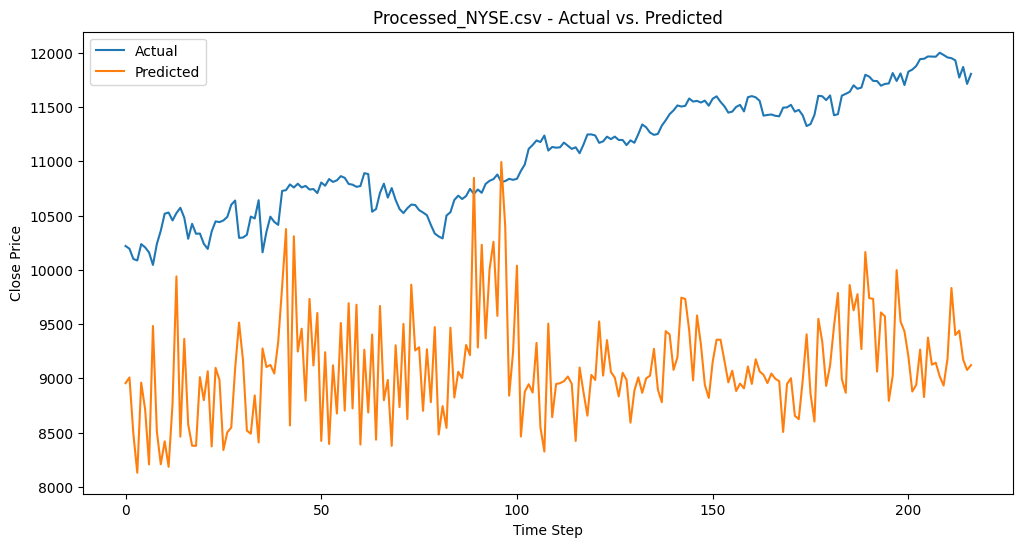

Model saved to model_Processed_NYSE.pth
✅ Finished processing dataset: Processed_NYSE.csv

--- Processing dataset: Processed_NASDAQ.csv ---
Current working directory: /content/Time-Series-Library/utils
Checking for file: Processed_NASDAQ.csv
Using numeric columns from Processed_NASDAQ.csv: ['Close', 'Volume', 'mom', 'mom1', 'mom2', 'mom3', 'ROC_5', 'ROC_10', 'ROC_15', 'ROC_20', 'EMA_10', 'EMA_20', 'EMA_50', 'EMA_200', 'DTB4WK', 'DTB3', 'DTB6', 'DGS5', 'DGS10', 'Oil', 'Gold', 'DAAA', 'DBAA', 'GBP', 'JPY', 'CAD', 'CNY', 'AAPL', 'AMZN', 'GE', 'JNJ', 'JPM', 'MSFT', 'WFC', 'XOM', 'FCHI', 'FTSE', 'GDAXI', 'GSPC', 'HSI', 'DJI', 'SSEC', 'RUT', 'NYSE', 'TE1', 'TE2', 'TE3', 'TE5', 'TE6', 'DE1', 'DE2', 'DE4', 'DE5', 'DE6', 'CTB3M', 'CTB6M', 'CTB1Y', 'AUD', 'Brent', 'CAC-F', 'copper-F', 'WIT-oil', 'DAX-F', 'DJI-F', 'EUR', 'FTSE-F', 'gold-F', 'HSI-F', 'KOSPI-F', 'NASDAQ-F', 'GAS-F', 'Nikkei-F', 'NZD', 'silver-F', 'RUSSELL-F', 'S&P-F', 'CHF', 'Dollar index-F', 'Dollar index', 'wheat-F', 'XAG', 'XAU'

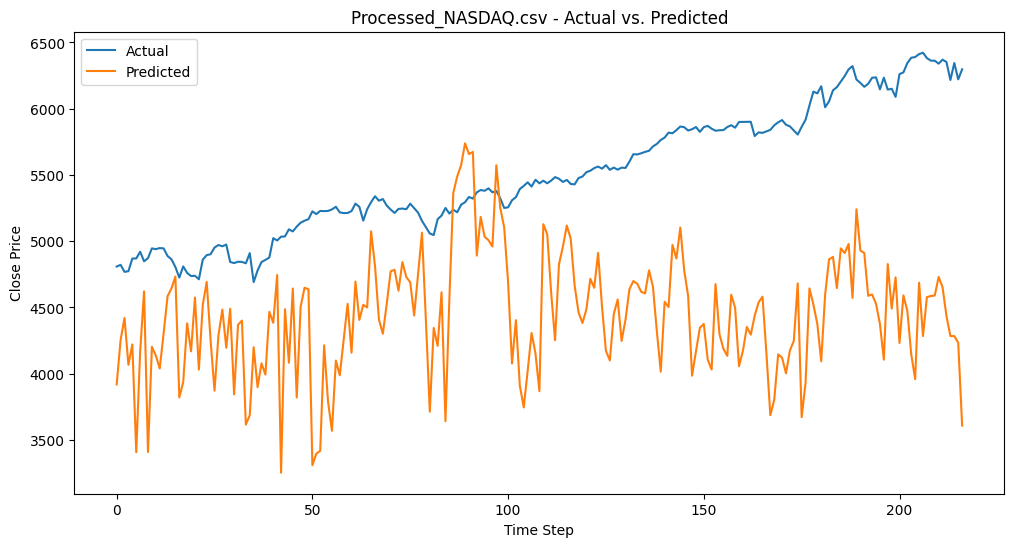

Model saved to model_Processed_NASDAQ.pth
✅ Finished processing dataset: Processed_NASDAQ.csv

--- Processing dataset: Processed_DJI.csv ---
Current working directory: /content/Time-Series-Library/utils
Checking for file: Processed_DJI.csv
Using numeric columns from Processed_DJI.csv: ['Close', 'Volume', 'mom', 'mom1', 'mom2', 'mom3', 'ROC_5', 'ROC_10', 'ROC_15', 'ROC_20', 'EMA_10', 'EMA_20', 'EMA_50', 'EMA_200', 'DTB4WK', 'DTB3', 'DTB6', 'DGS5', 'DGS10', 'Oil', 'Gold', 'DAAA', 'DBAA', 'GBP', 'JPY', 'CAD', 'CNY', 'AAPL', 'AMZN', 'GE', 'JNJ', 'JPM', 'MSFT', 'WFC', 'XOM', 'FCHI', 'FTSE', 'GDAXI', 'GSPC', 'HSI', 'IXIC', 'SSEC', 'RUT', 'NYSE', 'TE1', 'TE2', 'TE3', 'TE5', 'TE6', 'DE1', 'DE2', 'DE4', 'DE5', 'DE6', 'CTB3M', 'CTB6M', 'CTB1Y', 'AUD', 'Brent', 'CAC-F', 'copper-F', 'WIT-oil', 'DAX-F', 'DJI-F', 'EUR', 'FTSE-F', 'gold-F', 'HSI-F', 'KOSPI-F', 'NASDAQ-F', 'GAS-F', 'Nikkei-F', 'NZD', 'silver-F', 'RUSSELL-F', 'S&P-F', 'CHF', 'Dollar index-F', 'Dollar index', 'wheat-F', 'XAG', 'XAU']
Ep

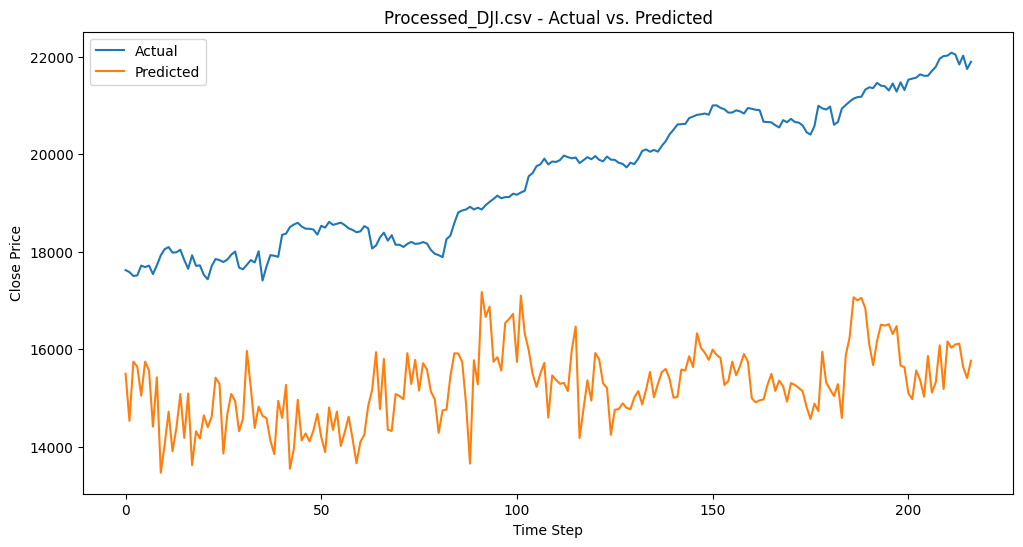

Model saved to model_Processed_DJI.pth
✅ Finished processing dataset: Processed_DJI.csv

🎉 All datasets processed successfully!


In [93]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from models.PatchTST import Model  # Make sure PatchTST.py is in models/
import os
from types import SimpleNamespace

# Dataset files to process
datasets = [
    "Processed_SP.csv",
    "Processed_RUSSELL.csv",
    "Processed_NYSE.csv",
    "Processed_NASDAQ.csv",
    "Processed_DJI.csv"
]

# Hyperparameters and model config
window_size = 30
pred_horizon = 1
d_model = 128
n_heads = 8
d_ff = 256
e_layers = 3
dropout = 0.1
factor = 5
activation = 'relu'
batch_size = 64
num_epochs = 10
learning_rate = 0.001

# --- Function to load and prepare data ---
def prepare_data_and_loaders(filename, window_size, pred_horizon, batch_size):
    print(f"Current working directory: {os.getcwd()}")
    print(f"Checking for file: {filename}")
    if not os.path.exists(filename):
        raise FileNotFoundError(f"File not found: {filename}")

    df = pd.read_csv(filename)
    if 'Date' in df.columns:
        df = df.drop(columns=["Date"])

    df_numeric = df.select_dtypes(include=[np.number])
    print(f"Using numeric columns from {filename}: {df_numeric.columns.tolist()}")
    num_features = df_numeric.shape[1]

    df_clean = df_numeric.dropna()
    data = df_clean.values
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)

    X, y = [], []
    for i in range(len(data_scaled) - window_size - pred_horizon + 1):
        X.append(data_scaled[i:i + window_size])
        y.append(data_scaled[i + window_size + pred_horizon - 1, 0])  # 0 = "Close"

    X = np.array(X)
    y = np.array(y)

    # Split into training and validation
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Convert to PyTorch Tensors
    train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
    val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, scaler, num_features

# --- Function to train and evaluate model ---
def train_and_evaluate(model, train_loader, val_loader, num_epochs, learning_rate, pred_len, task_name):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()

            # Get model output and reduce to [batch_size]
            outputs = model(batch_X, None, None, None)
            outputs = outputs.mean(dim=-1).squeeze()

            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {total_loss / len(train_loader):.4f}")

    # --- Evaluation ---
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            preds = model(batch_X, None, None, None)
            preds = preds.mean(dim=-1).squeeze()
            all_preds.append(preds.cpu().numpy())
            all_targets.append(batch_y.cpu().numpy())

    all_preds = np.concatenate(all_preds, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)
    mse = np.mean((all_preds - all_targets) ** 2)
    print(f"Validation MSE: {mse:.4f}")
    return all_preds, all_targets

# --- Main loop for all datasets ---
for dataset_name in datasets:
    print(f"\n--- Processing dataset: {dataset_name} ---")
    train_loader, val_loader, scaler, num_features = prepare_data_and_loaders(
        dataset_name, window_size, pred_horizon, batch_size
    )

    config = SimpleNamespace(
        task_name='long_term_forecast',
        seq_len=window_size,
        pred_len=pred_horizon,
        d_model=d_model,
        n_heads=n_heads,
        d_ff=d_ff,
        e_layers=e_layers,
        dropout=dropout,
        factor=factor,
        activation=activation,
        enc_in=num_features
    )

    model = Model(config)

    predictions, targets = train_and_evaluate(
        model, train_loader, val_loader,
        num_epochs, learning_rate, pred_horizon, config.task_name
    )

    # Inverse transform (scale back to original)
    predictions_original_scale = scaler.inverse_transform(
        np.concatenate([predictions.reshape(-1, 1), np.zeros((len(predictions), num_features - 1))], axis=1)
    )[:, 0]

    targets_original_scale = scaler.inverse_transform(
        np.concatenate([targets.reshape(-1, 1), np.zeros((len(targets), num_features - 1))], axis=1)
    )[:, 0]

    # --- Plot Results ---
    plt.figure(figsize=(12, 6))
    plt.plot(targets_original_scale, label='Actual')
    plt.plot(predictions_original_scale, label='Predicted')
    plt.title(f'{dataset_name} - Actual vs. Predicted')
    plt.xlabel('Time Step')
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()

    # --- Save Model ---
    model_path = f"model_{dataset_name.replace('.csv', '')}.pth"
    torch.save(model.state_dict(), model_path)
    print(f"Model saved to {model_path}")
    print(f"✅ Finished processing dataset: {dataset_name}")

print("\n🎉 All datasets processed successfully!")
